In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import jinja2
from dataprep.eda import create_report, plot, plot_correlation, plot_missing , plot_diff
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, median_absolute_error
import plotly.express as px

from lightgbm import LGBMClassifier, log_evaluation, LGBMRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, metrics
# from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from optuna.integration import CatBoostPruningCallback
from sklearn.base import BaseEstimator, TransformerMixin

import lightgbm as lgbm
from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import StratifiedKFold, train_test_split
# from imblearn.over_sampling import SMOTE
import optuna
import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor
from scipy.stats import ks_2samp

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
og = pd.read_csv('data.csv',sep=';')
train.shape, test.shape, og.shape

((76518, 38), (51012, 37), (4424, 37))

In [3]:
og.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd s

In [4]:
numerical = [i for i in train.columns if train[i].dtype!='O']

In [5]:
numerical.remove('id')

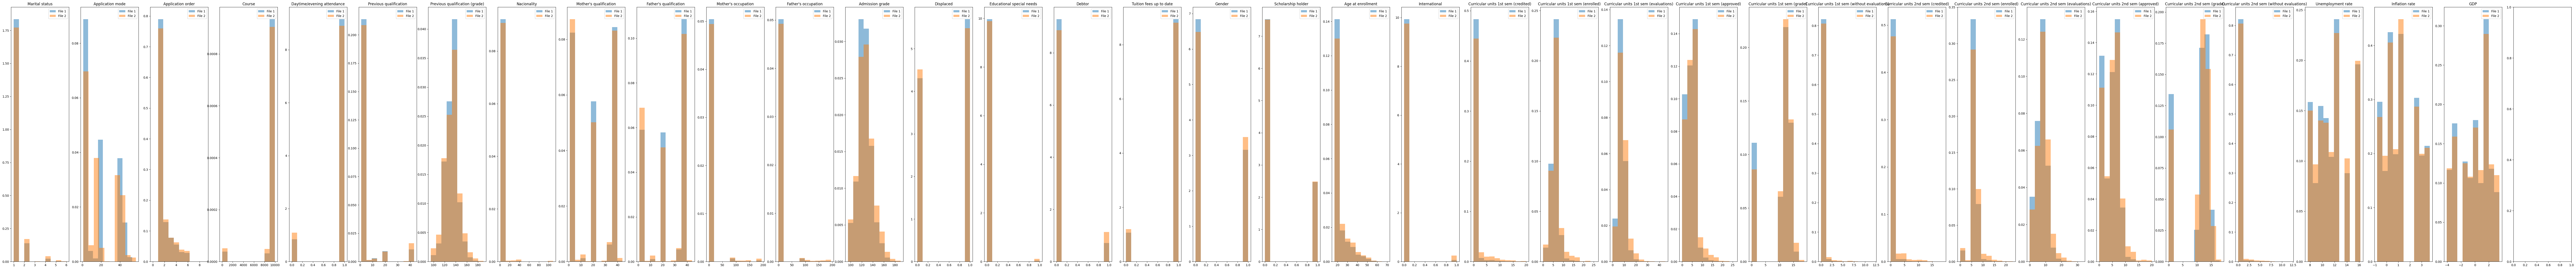

KS Statistic for Marital status: 0.0314375260519727, p-value: 0.0005027154313019685
KS Statistic for Application mode: 0.07429938715503692, p-value: 1.597220187094624e-20
KS Statistic for Application order: 0.026512305936879144, p-value: 0.005493373759873535
KS Statistic for Course: 0.05261333396857726, p-value: 1.678577188748859e-10
KS Statistic for Daytime/evening attendance: 0.02449125894428414, p-value: 0.013030083421252534
KS Statistic for Previous qualification: 0.037812688071078515, p-value: 1.2446379532775546e-05
KS Statistic for Previous qualification (grade): 0.04282889955285729, p-value: 4.199740365532426e-07
KS Statistic for Nacionality: 0.018264621824022553, p-value: 0.12129715869551605
KS Statistic for Mother's qualification: 0.02878017166427338, p-value: 0.0019211363567677706
KS Statistic for Father's qualification: 0.05090120033216072, p-value: 7.412284563767001e-10
KS Statistic for Mother's occupation: 0.0538819962086714, p-value: 5.410192783866743e-11
KS Statistic for

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=len(train.drop('id',axis=1).columns), figsize=(150, 15))

for i, col in enumerate(numerical):
    axes[i].hist(train[col], alpha=0.5, label='File 1', density=True)
    axes[i].hist(og[col], alpha=0.5, label='File 2', density=True)
    axes[i].set_title(col)
    axes[i].legend()

plt.show()

# Perform KS test for each column
for col in numerical:
    ks_statistic, p_value = ks_2samp(train[col], og[col])
    print(f"KS Statistic for {col}: {ks_statistic}, p-value: {p_value}")

# You can interpret the p-value to determine if the distributions are significantly different
# Typically, if p-value is less than a significance level (e.g., 0.05), you reject the null hypothesis that distributions are the same

In [7]:
train.drop('id',axis=1, inplace=True)
test.drop('id',axis=1, inplace=True)

train = pd.concat([train, og],ignore_index=True)
train.shape, test.shape

((80942, 37), (51012, 36))

In [8]:
train.head()

Marital status  Application mode  Application order  Course  \
0               1                 1                  1    9238   
1               1                17                  1    9238   
2               1                17                  2    9254   
3               1                 1                  3    9500   
4               1                 1                  2    9500   

   Daytime/evening attendance  Previous qualification  \
0                           1                       1   
1                           1                       1   
2                           1                       1   
3                           1                       1   
4                           1                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           126.0            1                       1   
1                           125.0            1                      19   
2                           137.0            1                       3   
3                           131.0            1                      19   
4                           132.0            1                      19   

   Father's qualification  ...  Curricular units 2nd sem (credited)  \
0                      19  ...                                    0   
1                      19  ...                                    0   
2                      19  ...                                    0   
3                       3  ...                                    0   
4                      37  ...                                    0   

   Curricular units 2nd sem (enrolled)  \
0                                    6   
1                                    6   
2                                    6   
3                                    8   
4                                    7   

   Curricular units 2nd sem (evaluations)  \
0                                       7   
1                                       9   
2                                       0   
3                                      11   
4                                      12   

   Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
0                                    6                         12.428571   
1                                    0                          0.000000   
2                                    0                          0.000000   
3                                    7                         12.820000   
4                                    6                         12.933333   

   Curricular units 2nd sem (without evaluations)  Unemployment rate  \
0                                               0               11.1   
1                                               0               11.1   
2                                               0               16.2   
3                                               0               11.1   
4                                               0                7.6   

   Inflation rate   GDP    Target  
0             0.6  2.02  Graduate  
1             0.6  2.02   Dropout  
2             0.3 -0.92   Dropout  
3             0.6  2.02  Enrolled  
4             2.6  0.32  Graduate  

[5 rows x 37 columns]

In [9]:
train[numerical].describe().T

count         mean  \
Marital status                                  80942.0     1.115577   
Application mode                                80942.0    16.197326   
Application order                               80942.0     1.648971   
Course                                          80942.0  8993.380668   
Daytime/evening attendance                      80942.0     0.913975   
Previous qualification                          80942.0     3.708989   
Previous qualification (grade)                  80942.0   132.391585   
Nacionality                                     80942.0     1.261941   
Mother's qualification                          80942.0    19.822564   
Father's qualification                          80942.0    23.362235   
Mother's occupation                             80942.0     8.713153   
Father's occupation                             80942.0     8.999691   
Admission grade                                 80942.0   125.452195   
Displaced                                       80942.0     0.568123   
Educational special needs                       80942.0     0.004163   
Debtor                                          80942.0     0.073695   
Tuition fees up to date                         80942.0     0.892936   
Gender                                          80942.0     0.317783   
Scholarship holder                              80942.0     0.247449   
Age at enrollment                               80942.0    22.332571   
International                                   80942.0     0.007623   
Curricular units 1st sem (credited)             80942.0     0.217353   
Curricular units 1st sem (enrolled)             80942.0     5.912233   
Curricular units 1st sem (evaluations)          80942.0     7.404104   
Curricular units 1st sem (approved)             80942.0     4.207383   
Curricular units 1st sem (grade)                80942.0    10.031113   
Curricular units 1st sem (without evaluations)  80942.0     0.062316   
Curricular units 2nd sem (credited)             80942.0     0.159176   
Curricular units 2nd sem (enrolled)             80942.0     5.949742   
Curricular units 2nd sem (evaluations)          80942.0     7.279768   
Curricular units 2nd sem (approved)             80942.0     4.030627   
Curricular units 2nd sem (grade)                80942.0     9.659104   
Curricular units 2nd sem (without evaluations)  80942.0     0.067246   
Unemployment rate                               80942.0    11.522844   
Inflation rate                                  80942.0     1.228208   
GDP                                             80942.0    -0.076391   

                                                        std    min  \
Marital status                                     0.452426   1.00   
Application mode                                  16.737628   1.00   
Application order                                  1.234530   0.00   
Course                                          1818.900599  33.00   
Daytime/evening attendance                         0.280402   0.00   
Previous qualification                             8.720782   1.00   
Previous qualification (grade)                    11.126395  95.00   
Nacionality                                        3.675890   1.00   
Mother's qualification                            15.410691   1.00   
Father's qualification                            14.946722   1.00   
Mother's occupation                               18.083198   0.00   
Father's occupation                               17.379674   0.00   
Admission grade                                   12.679973  95.00   
Displaced                                          0.495341   0.00   
Educational special needs                          0.064391   0.00   
Debtor                                             0.261275   0.00   
Tuition fees up to date                            0.309197   0.00   
Gender                                             0.465618   0.00   
Scholarship holder                                 0.43

In [10]:
train.isna().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

In [11]:
numerical = [col for col in train.columns if train[col].dtype !='O']
categorical = [col for col in train.columns if train[col].dtype =='O']
numerical, categorical

(['Marital status',
  'Application mode',
  'Application order',
  'Course',
  'Daytime/evening attendance',
  'Previous qualification',
  'Previous qualification (grade)',
  'Nacionality',
  "Mother's qualification",
  "Father's qualification",
  "Mother's occupation",
  "Father's occupation",
  'Admission grade',
  'Displaced',
  'Educational special needs',
  'Debtor',
  'Tuition fees up to date',
  'Gender',
  'Scholarship holder',
  'Age at enrollment',
  'International',
  'Curricular units 1st sem (credited)',
  'Curricular units 1st sem (enrolled)',
  'Curricular units 1st sem (evaluations)',
  'Curricular units 1st sem (approved)',
  'Curricular units 1st sem (grade)',
  'Curricular units 1st sem (without evaluations)',
  'Curricular units 2nd sem (credited)',
  'Curricular units 2nd sem (enrolled)',
  'Curricular units 2nd sem (evaluations)',
  'Curricular units 2nd sem (approved)',
  'Curricular units 2nd sem (grade)',
  'Curricular units 2nd sem (without evaluations)',
  'U

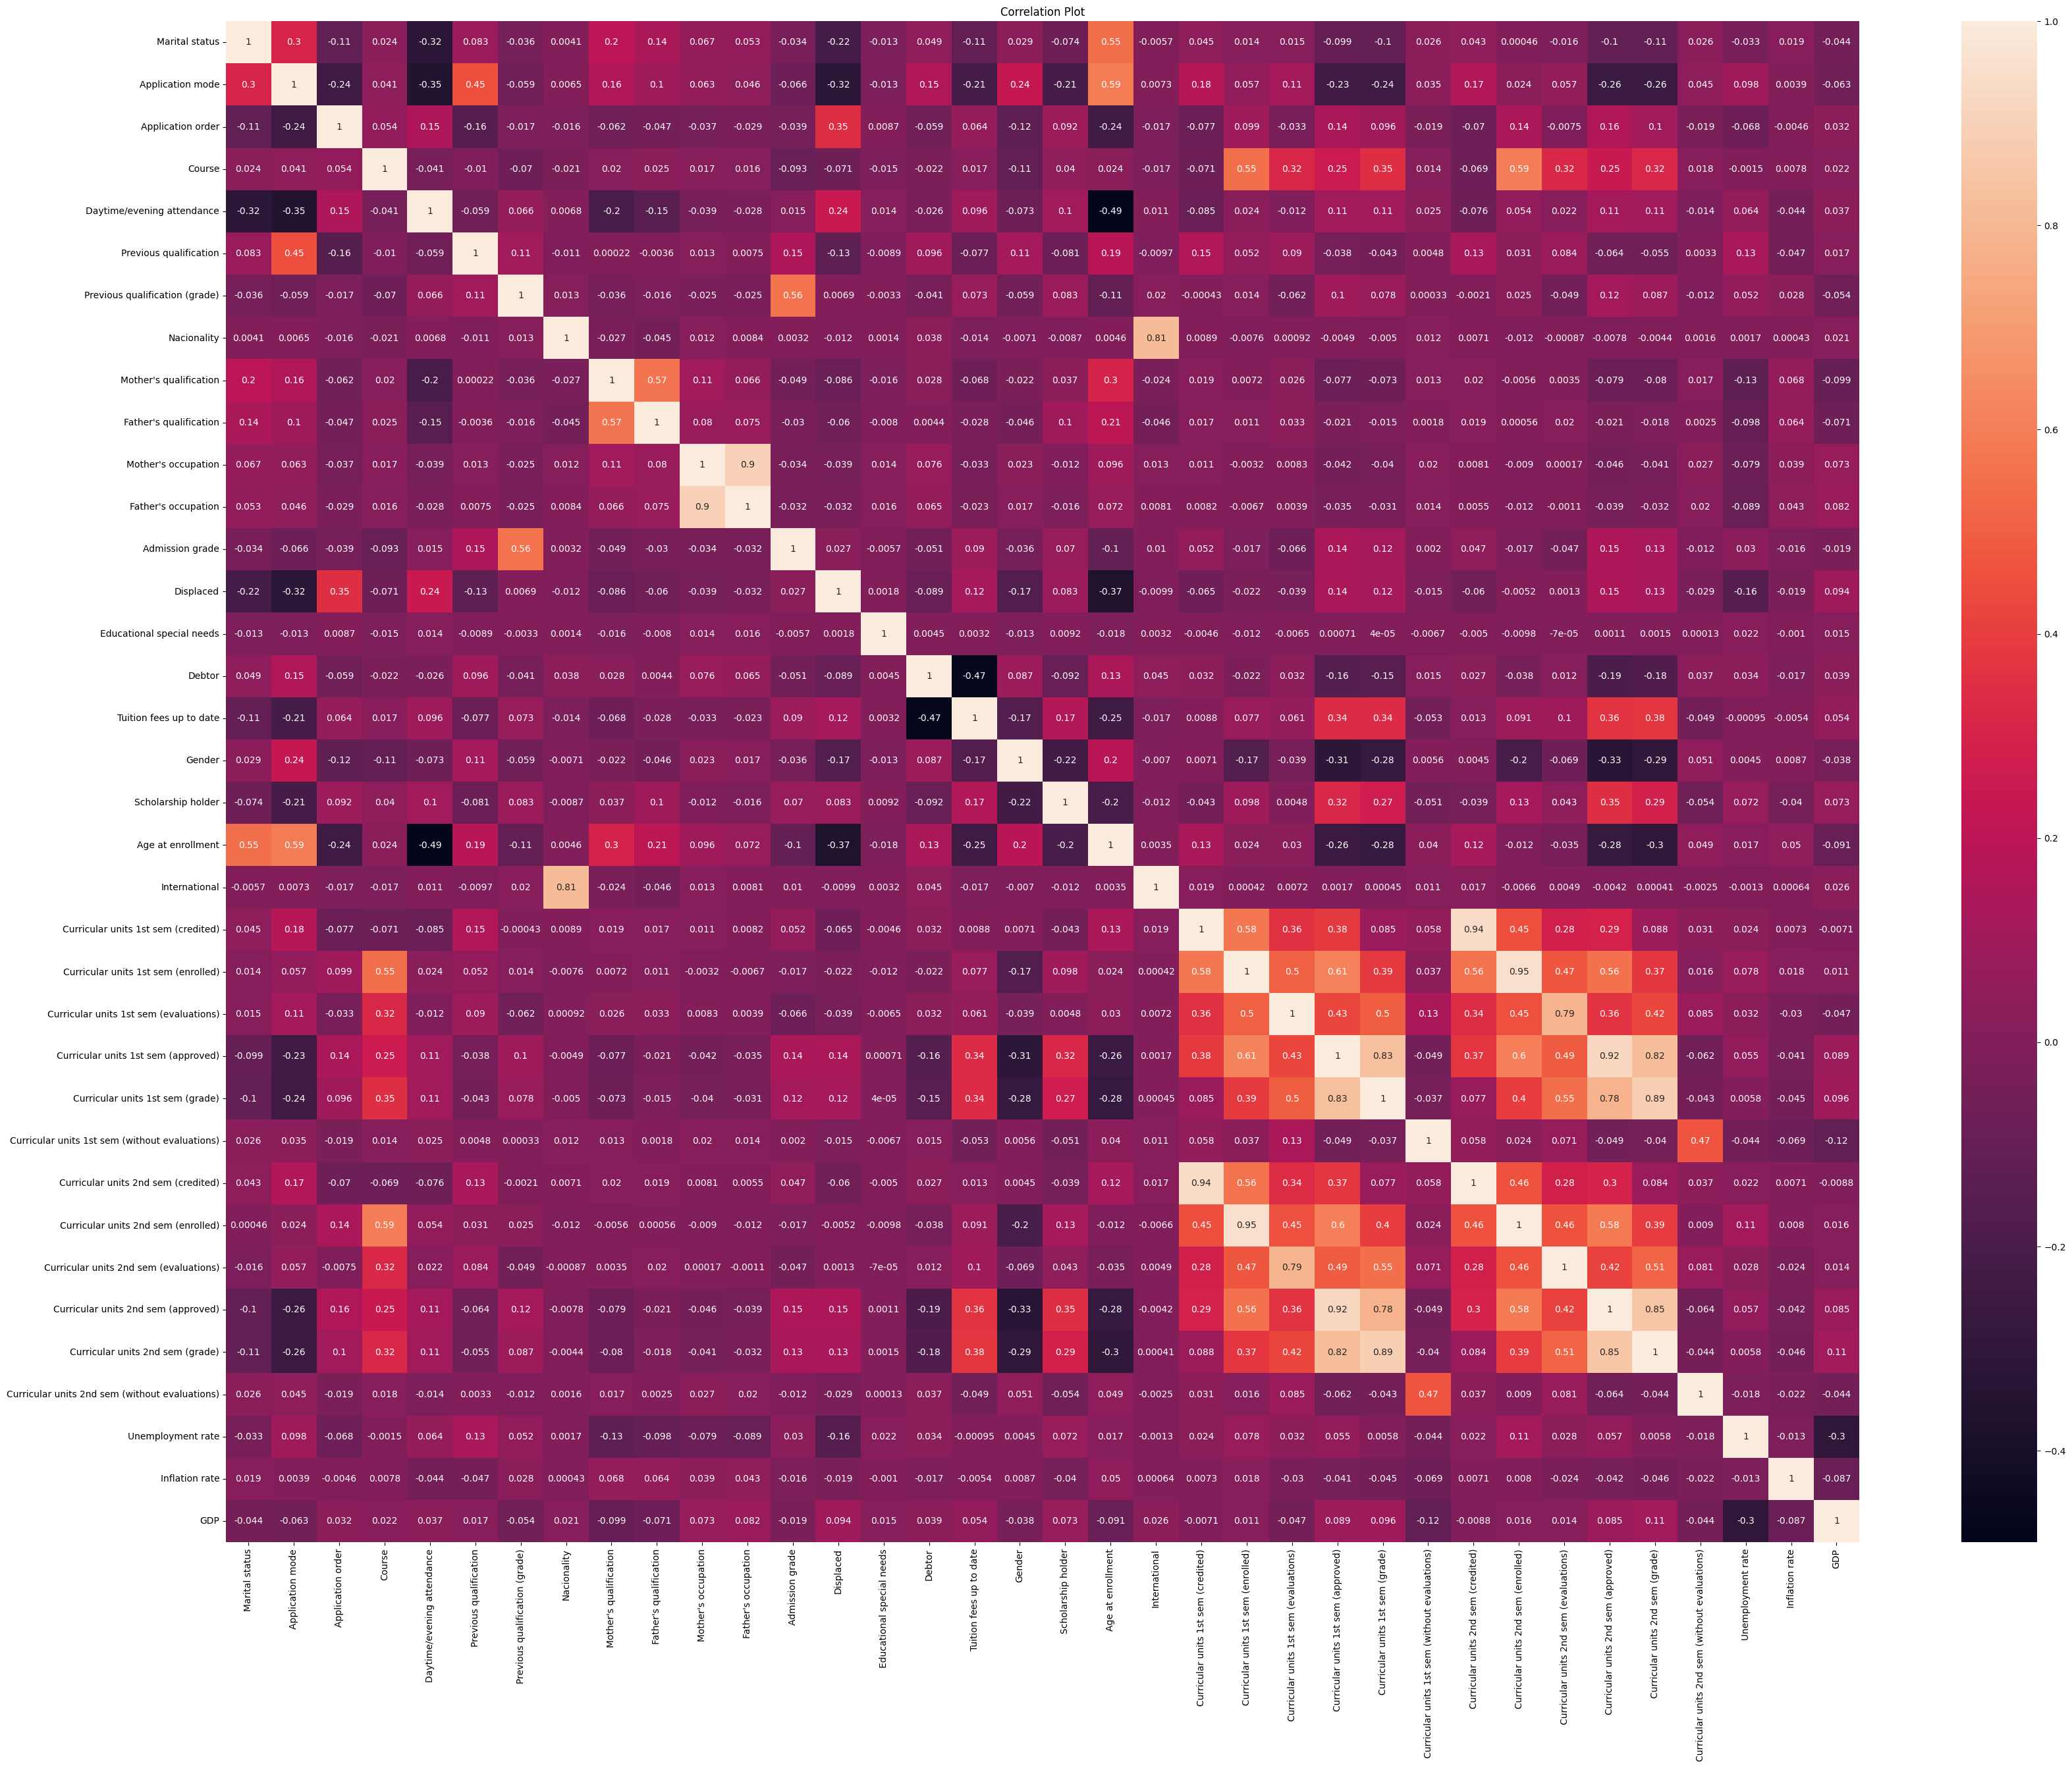

In [12]:
correlation_matrix = train[numerical].corr()
plt.figure(figsize=(40, 30))
color_palette = sns.color_palette('viridis', as_cmap=True)
# Create a heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True)

# Show the plot
plt.title('Correlation Plot')
plt.show()

In [13]:
train['Target'].value_counts()

Target
Graduate    38491
Dropout     26717
Enrolled    15734
Name: count, dtype: int64

In [14]:
train_data = TabularDataset(train)
test_data = TabularDataset(test)
# predictor = TabularPredictor(problem_type='multiclass',label='NObeyesdad',eval_metric='accuracy').fit(train_data=train_data,presets='best_quality',ag_args_fit={'num_gpus': 1},time_limit=7200,hyperparameters={'GBM':{},'CAT':{},'XT':{},'XGB':{}},)
predictor = TabularPredictor(problem_type='multiclass',label='Target',eval_metric='roc_auc_ovo_macro').fit(train_data=train_data,presets='best_quality',ag_args_fit={'num_gpus': 1},time_limit=3600)
predictions = predictor.predict(test_data)

No path specified. Models will be saved in: "AutogluonModels\ag-20240609_172229"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 3600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels\ag-20240609_172229/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "AutogluonModels\ag-20240609_172229/ds_sub_fit/sub_fit_ho"
=================== System Info ===================
AutoGluon Version:  1.

In [34]:
predictor.leaderboard()

model  score_val eval_metric  pred_time_val  \
0           WeightedEnsemble_L3   0.833449    accuracy      83.336711   
1        NeuralNetFastAI_BAG_L2   0.832979    accuracy      72.930373   
2          LightGBM_r131_BAG_L1   0.832781    accuracy      17.698070   
3           WeightedEnsemble_L2   0.832781    accuracy      17.703060   
4     NeuralNetTorch_r79_BAG_L2   0.832781    accuracy      72.833532   
5                XGBoost_BAG_L2   0.832510    accuracy      72.777164   
6          LightGBMLarge_BAG_L2   0.832411    accuracy      73.289751   
7          CatBoost_r177_BAG_L2   0.832337    accuracy      72.178526   
8               LightGBM_BAG_L2   0.832287    accuracy      72.544041   
9               CatBoost_BAG_L2   0.832226    accuracy      72.176612   
10        NeuralNetTorch_BAG_L2   0.832213    accuracy      72.777862   
11            LightGBMXT_BAG_L2   0.831830    accuracy      72.781636   
12               XGBoost_BAG_L1   0.831694    accuracy       1.731857   
13              LightGBM_BAG_L1   0.831546    accuracy       3.111159   
14        ExtraTreesGini_BAG_L2   0.831138    accuracy      76.579087   
15         LightGBMLarge_BAG_L1   0.831089    accuracy       5.167217   
16            LightGBMXT_BAG_L1   0.830867    accuracy       8.903727   
17        ExtraTreesEntr_BAG_L2   0.830867    accuracy      76.399855   
18      RandomForestEntr_BAG_L2   0.830249    accuracy      76.123677   
19      RandomForestGini_BAG_L2   0.829940    accuracy      76.477061   
20         CatBoost_r177_BAG_L1   0.829532    accuracy       0.056093   
21              CatBoost_BAG_L1   0.827778    accuracy       0.054661   
22           CatBoost_r9_BAG_L1   0.827679    accuracy       0.080090   
23       NeuralNetFastAI_BAG_L1   0.824183    accuracy       0.722767   
24  NeuralNetFastAI_r191_BAG_L1   0.824133    accuracy       0.775431   
25      RandomForestGini_BAG_L1   0.824072    accuracy       3.063345   
26    NeuralNetTorch_r79_BAG_L1   0.823775    accuracy       0.350384   
27      RandomForestEntr_BAG_L1   0.823750    accuracy       3.014024   
28        NeuralNetTorch_BAG_L1   0.822750    accuracy       0.312962   
29        ExtraTreesEntr_BAG_L1   0.822601    accuracy       2.687740   
30        ExtraTreesGini_BAG_L1   0.822441    accuracy       2.598929   
31          LightGBM_r96_BAG_L1   0.821465    accuracy       6.903820   
32         LightGBM_r131_BAG_L2   0.820761    accuracy      72.580701   
33        KNeighborsDist_BAG_L1   0.736120    accuracy       7.633754   
34        KNeighborsUnif_BAG_L1   0.733426    accuracy       7.269478   

       fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0   4919.653607                0.006001          18.947006            3   
1   4022.139696                0.794863         526.112100            2   
2    451.726550               17.698070         451.726550            1   
3    465.974984                0.004990          14.248434            2   
4   3798.889727                0.698022         302.862131            2   
5   3535.910421                0.641654          39.882825            2   
6   3656.880055                1.154241         160.852458            2   
7   3536.550522                0.043016          40.522926            2   
8   3550.066893                0.408531          54.039297            2   
9   3534.789357                0.041102          38.761761            2   
10  3842.113128                0.642352         346.085532            2   
11  3550.974630                0.646126          54.947034            2   
12    43.232958                1.731857          43.232958            1   
13    97.694278                3.111159          97.694278            1   
14  3502.799314                4.443577           6.771718            2   
15   236.620106                5.167217         236.620106            1   
16   194.527630                8.903727         194.527630            1   
17  3502.766892                4.264345        

In [36]:
predictor.feature_importance(train_data)

Computing feature importance via permutation shuffling for 36 features using 5000 rows with 5 shuffle sets...
	2328.71s	= Expected runtime (465.74s per shuffle set)
	1080.61s	= Actual runtime (Completed 5 of 5 shuffle sets)


importance    stddev  \
Curricular units 2nd sem (approved)                0.21612  0.004632   
Curricular units 1st sem (approved)                0.04312  0.004268   
Tuition fees up to date                            0.03884  0.003057   
Curricular units 2nd sem (grade)                   0.02408  0.002100   
Curricular units 2nd sem (evaluations)             0.02196  0.003369   
Course                                             0.01792  0.003158   
Curricular units 1st sem (grade)                   0.01712  0.001566   
Admission grade                                    0.01684  0.001152   
Scholarship holder                                 0.01556  0.001108   
Age at enrollment                                  0.01532  0.003273   
Curricular units 2nd sem (enrolled)                0.01412  0.002834   
Curricular units 1st sem (evaluations)             0.01308  0.001474   
Previous qualification (grade)                     0.01216  0.000713   
Application mode                                   0.01216  0.001330   
Mother's occupation                                0.01052  0.001747   
Mother's qualification                             0.01036  0.001299   
Unemployment rate                                  0.00940  0.002205   
Father's occupation                                0.00932  0.002207   
GDP                                                0.00928  0.001604   
Gender                                             0.00908  0.000890   
Father's qualification                             0.00828  0.000832   
Curricular units 1st sem (enrolled)                0.00696  0.001381   
Displaced                                          0.00604  0.001126   
Inflation rate                                     0.00580  0.001049   
Application order                                  0.00536  0.000385   
Debtor                                             0.00492  0.001254   
Previous qualification                             0.00236  0.000713   
Curricular units 2nd sem (credited)                0.00228  0.001331   
Curricular units 1st sem (credited)                0.00224  0.000740   
Daytime/evening attendance                         0.00196  0.000910   
Curricular units 2nd sem (without evaluations)     0.00148  0.000303   
Curricular units 1st sem (without evaluations)     0.00120  0.000490   
Marital status                                     0.00092  0.000965   
Educational special needs                          0.00044  0.000329   
Nacionality                                        0.00040  0.000316   
International                                      0.00024  0.000167   

                                                     p_value  n  p99_high  \
Curricular units 2nd sem (approved)             2.529712e-08  5  0.225657   
Curricular units 1st sem (approved)             1.136399e-05  5  0.051907   
Tuition fees up to date                         4.570061e-06  5  0.045135   
Curricular units 2nd sem (grade)                6.877540e-06  5  0.028405   
Curricular units 2nd sem (evaluations)          6.441480e-05  5  0.028896   
Course                                          1.110766e-04  5  0.024422   
Curricular units 1st sem (grade)                8.305738e-06  5  0.020344   
Admission grade                                 2.615184e-06  5  0.019213   
Scholarship holder                              3.066255e-06  5  0.017842   
Age at enrollment                               2.354563e-04  5  0.022059   
Curricular units 2nd sem (enrolled)             1.847203e-04  5  0.019955   
Curricular units 1st sem (evaluations)          1.901753e-05  5  0.016115   
Previous qualification (grade)                  1.409898e-06  5  0.013628   
Application mode                                1.688571e-05  5  0.014898   
Mother's occupation                             8.800044e-05  5  0.014117   
Mother's qualification                          2.906930e-05  5  0.013035   
Unemployment rate                               3.378669e-04  5  0.013939 

In [38]:
predictor.features()

['Marital status',
 'Application mode',
 'Application order',
 'Course',
 'Daytime/evening attendance',
 'Previous qualification',
 'Previous qualification (grade)',
 'Nacionality',
 "Mother's qualification",
 "Father's qualification",
 "Mother's occupation",
 "Father's occupation",
 'Admission grade',
 'Displaced',
 'Educational special needs',
 'Debtor',
 'Tuition fees up to date',
 'Gender',
 'Scholarship holder',
 'Age at enrollment',
 'International',
 'Curricular units 1st sem (credited)',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (grade)',
 'Curricular units 1st sem (without evaluations)',
 'Curricular units 2nd sem (credited)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (grade)',
 'Curricular units 2nd sem (without evaluations)',
 'Unemployment rate',
 'Inflation rat

In [39]:
y_proba = predictor.predict(test)

In [41]:
y_proba

0         Dropout
1        Graduate
2        Graduate
3        Enrolled
4        Enrolled
           ...   
51007     Dropout
51008     Dropout
51009     Dropout
51010     Dropout
51011     Dropout
Name: Target, Length: 51012, dtype: object

In [42]:
sample = pd.read_csv('sample_submission.csv')
sample.head()
submission = pd.DataFrame({'id':sample.id,'NObeyesdad':y_proba})
submission.to_csv('Autog-out.csv',index=False)
submission.head()

id NObeyesdad
0  76518    Dropout
1  76519   Graduate
2  76520   Graduate
3  76521   Enrolled
4  76522   Enrolled

FLAML

In [16]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data = train_data.drop("id", axis=1)
og = pd.read_csv('data.csv',sep=';')
train_data = pd.concat([train_data, og], ignore_index=True)

num_cols = list(train_data.select_dtypes(exclude=['object']).columns)
cat_cols = list(train_data.select_dtypes(include=['object']).columns)

num_cols_test = list(test_data.select_dtypes(exclude=['object']).columns)
cat_cols_test = list(test_data.select_dtypes(include=['object']).columns)

num_cols_test = [col for col in num_cols_test if col not in ['id']]

In [17]:
scaler = StandardScaler()
train_data[num_cols] = scaler.fit_transform(train_data[num_cols])
test_data[num_cols_test] = scaler.transform(test_data[num_cols_test])

In [18]:
labelencoder = LabelEncoder()
object_columns = train_data.select_dtypes(include='object').columns.difference(['Target'])

for col_name in object_columns:
    if train_data[col_name].dtypes=='object':
        train_data[col_name]=labelencoder.fit_transform(train_data[col_name])
        
for col_name in test_data.columns:
    if test_data[col_name].dtypes=='object':
        test_data[col_name]=labelencoder.fit_transform(test_data[col_name])

In [19]:
X = train_data.drop(['Target'], axis=1)
y = train_data['Target']
y = labelencoder.fit_transform(y)
X_test = test_data.drop(["id"],axis=1)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)

In [15]:
from flaml import AutoML

In [28]:
# Initialize an AutoML instance
FL_automl = AutoML()

# Specify automl goal and constraint
FL_automl_settings = {
    # in seconds    
#    "time_budget": 1800, 
    "time_budget": 3600,  
#     "estimator_list": ['lgbm', 'xgboost'],
#     "metric": 'accuracy',
    "metric": 'roc_auc_ovo',
#     "metric": 'log_loss',
    "task": 'classification',
    "n_jobs": -1,
    "eval_method": 'cv',
    "n_splits":5,
    "log_file_name": 'mylog.log',
}

In [29]:
FL_automl.fit(X_train, y_train, **FL_automl_settings)

[flaml.automl.logger: 06-09 20:31:08] {1680} INFO - task = classification
[flaml.automl.logger: 06-09 20:31:08] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 06-09 20:31:08] {1789} INFO - Minimizing error metric: 1-roc_auc_ovo
[flaml.automl.logger: 06-09 20:31:08] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 06-09 20:31:08] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-09 20:31:08] {2345} INFO - Estimated sufficient time budget=5569s. Estimated necessary time budget=137s.
[flaml.automl.logger: 06-09 20:31:08] {2392} INFO -  at 0.8s,	estimator lgbm's best error=0.1160,	best estimator lgbm's best error=0.1160
[flaml.automl.logger: 06-09 20:31:08] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-09 20:31:09] {2392} INFO -  at 1.4s,	estimator lgbm's best error=0.1160,	best estimator lgbm's best error=0.1160
[flaml.automl.logg

No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.p

[flaml.automl.logger: 06-09 20:41:47] {2392} INFO -  at 639.6s,	estimator lrl1's best error=0.0902,	best estimator lgbm's best error=0.0728
[flaml.automl.logger: 06-09 20:41:47] {2219} INFO - iteration 96, current learner lrl1


c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[flaml.automl.logger: 06-09 20:42:10] {2392} INFO -  at 662.0s,	estimator lrl1's best error=0.0902,	best estimator lgbm's best error=0.0728
[flaml.automl.logger: 06-09 20:42:10] {2219} INFO - iteration 97, current learner rf


c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-09 20:42:10] {2392} INFO -  at 662.4s,	estimator rf's best error=0.1054,	best estimator lgbm's best error=0.0728
[flaml.automl.logger: 06-09 20:42:10] {2219} INFO - iteration 98, current learner lrl1
[flaml.automl.logger: 06-09 20:42:19] {2392} INFO -  at 671.7s,	estimator lrl1's best error=0.0901,	best estimator lgbm's best error=0.0728
[flaml.automl.logger: 06-09 20:42:19] {2219} INFO - iteration 99, current learner xgboost
[flaml.automl.logger: 06-09 20:42:22] {2392} INFO -  at 674.3s,	estimator xgboost's best error=0.0747,	best estimator lgbm's best error=0.0728
[flaml.automl.logger: 06-09 20:42:22] {2219} INFO - iteration 100, current learner xgboost
[flaml.automl.logger: 06-09 20:42:23] {2392} INFO -  at 675.5s,	estimator xgboost's best error=0.0747,	best estimator lgbm's best error=0.0728
[flaml.automl.logger: 06-09 20:42:23] {2219} INFO - iteration 101, current learner xgboost
[flaml.automl.logger: 06-09 20:42:31] {2392} INFO -  at 683.1s,	estimator xgb

In [28]:
model_lgbm = LGBMClassifier(colsample_bytree=0.5219137979097764,
               learning_rate=0.02259846401043735, max_bin=1023,
               min_child_samples=15, n_estimators=1189, num_leaves=44,
               reg_alpha=0.0009765625, reg_lambda=0.11335128586062176,
               verbose=-1,objective='multiclass')
model_lgbm.fit(X_train, y_train, eval_set=(X_val, y_val),eval_metric='multi_logloss')

[1]	valid_0's multi_logloss: 1.01464
[2]	valid_0's multi_logloss: 0.993125
[3]	valid_0's multi_logloss: 0.971743
[4]	valid_0's multi_logloss: 0.952097
[5]	valid_0's multi_logloss: 0.934714
[6]	valid_0's multi_logloss: 0.916593
[7]	valid_0's multi_logloss: 0.899793
[8]	valid_0's multi_logloss: 0.883657
[9]	valid_0's multi_logloss: 0.869479
[10]	valid_0's multi_logloss: 0.856801
[11]	valid_0's multi_logloss: 0.842576
[12]	valid_0's multi_logloss: 0.828893
[13]	valid_0's multi_logloss: 0.815744
[14]	valid_0's multi_logloss: 0.803305
[15]	valid_0's multi_logloss: 0.790604
[16]	valid_0's multi_logloss: 0.778431
[17]	valid_0's multi_logloss: 0.767326
[18]	valid_0's multi_logloss: 0.757345
[19]	valid_0's multi_logloss: 0.747131
[20]	valid_0's multi_logloss: 0.737408
[21]	valid_0's multi_logloss: 0.728265
[22]	valid_0's multi_logloss: 0.718656
[23]	valid_0's multi_logloss: 0.709436
[24]	valid_0's multi_logloss: 0.700817
[25]	valid_0's multi_logloss: 0.692442
[26]	valid_0's multi_logloss: 0.684

LGBMClassifier(colsample_bytree=0.5219137979097764,
               learning_rate=0.02259846401043735, max_bin=1023,
               min_child_samples=15, n_estimators=1189, num_leaves=44,
               objective='multiclass', reg_alpha=0.0009765625,
               reg_lambda=0.11335128586062176, verbose=-1)

In [35]:
# Model performance
def model_performance (p_test, p_train, p_test_prob, p_train_prob, y_test, y_train, model_name):
    global df_performance
    predicted_test = pd.DataFrame(p_test)
    predicted_train = pd.DataFrame(p_train)
    print('=============================================')
    print('Scoring Metrics for {} (Validation)'.format(model_name))
    print('Balanced Accuracy Score = {:2.3f}'.format(metrics.balanced_accuracy_score(y_test, predicted_test)))
    print('Accuracy Score = {:2.3f}'.format(metrics.accuracy_score(y_test, predicted_test)))
    metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, predicted_test)).plot()


    print('=============================================')
    print('Scoring Metrics for {} (Training)'.format(model_name))
    print('Balanced Accuracy Score = {:2.3f}'.format(metrics.balanced_accuracy_score(y_train, predicted_train)))
    print('Accuracy Score = {:2.3f}'.format(metrics.accuracy_score(y_train, predicted_train)))
    metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_train, predicted_train)).plot()


    plt.show()

In [36]:
p_train_FLAML = model_lgbm.predict(X_train)
p_test_FLAML = model_lgbm.predict(X_val)
p_train_proba_FLAML = model_lgbm.predict_proba(X_train)[:,1]
p_test_proba_FLAML = model_lgbm.predict_proba(X_val)[:,1]

Scoring Metrics for FLAML (Validation)
Balanced Accuracy Score = 0.791
Accuracy Score = 0.836
Scoring Metrics for FLAML (Training)
Balanced Accuracy Score = 0.861
Accuracy Score = 0.891


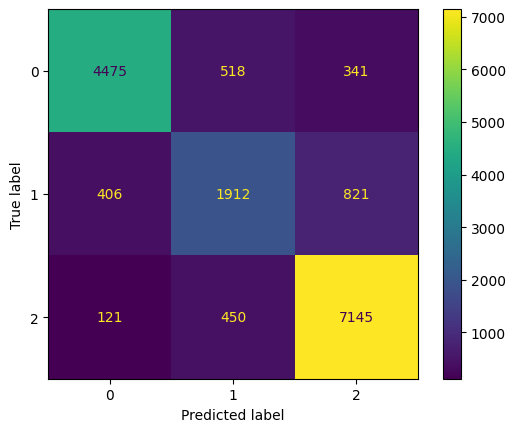

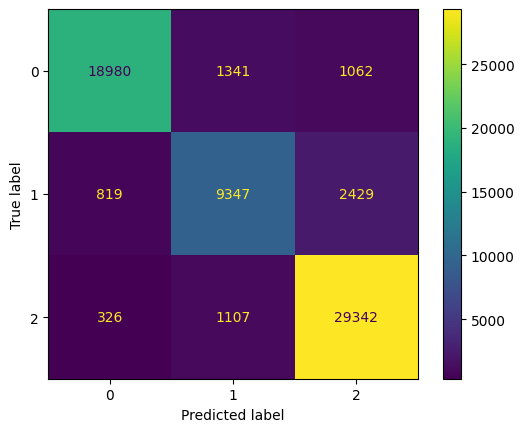

In [37]:
model_performance(p_test_FLAML, p_train_FLAML, p_test_proba_FLAML, p_train_proba_FLAML, y_val, y_train, 'FLAML')

In [33]:
pred_label = FL_automl.predict(X_test)
pred = labelencoder.inverse_transform(pred_label)

In [36]:
sample = pd.read_csv('sample_submission.csv')
sample.head()
submission = pd.DataFrame({'id':sample.id,'Target':pred})
submission.to_csv('flaml-out.csv',index=False)
submission.head()

id    Target
0  76518   Dropout
1  76519  Graduate
2  76520  Graduate
3  76521  Enrolled
4  76522  Enrolled

In [45]:
predictor = TabularPredictor.load(r"AutogluonModels\ag-20240609_120034")

In [47]:
test.drop('id',axis=1,inplace=True)

In [39]:
auto_pred = predictor.predict_proba(test)
flaml_pred = model_lgbm.predict_proba(X_test)

In [40]:
prob_models = [flaml_pred,auto_pred]
average_prob = np.mean(prob_models,axis=0)
average_prob

array([[0.99525141, 0.00301619, 0.00173241],
       [0.00413669, 0.01109187, 0.98477144],
       [0.03256623, 0.22104786, 0.74638592],
       ...,
       [0.97434104, 0.01455848, 0.01110047],
       [0.91504046, 0.07157869, 0.01338088],
       [0.98458282, 0.00609815, 0.00931903]])

In [41]:
prob_models = [flaml_pred,auto_pred]
average_prob = np.mean(prob_models,axis=0)
average_prob

array([[0.99525141, 0.00301619, 0.00173241],
       [0.00413669, 0.01109187, 0.98477144],
       [0.03256623, 0.22104786, 0.74638592],
       ...,
       [0.97434104, 0.01455848, 0.01110047],
       [0.91504046, 0.07157869, 0.01338088],
       [0.98458282, 0.00609815, 0.00931903]])

In [42]:
final_decision = np.argmax(average_prob, axis=1)
final_decision

array([0, 2, 2, ..., 0, 0, 0], dtype=int64)

In [44]:
pred = labelencoder.inverse_transform(final_decision)
sample = pd.read_csv('sample_submission.csv')
sample.head()
submission = pd.DataFrame({'id':sample.id,'Target':pred})
submission.to_csv('flaml-autog-ens-final.csv',index=False)
submission.head()

id    Target
0  76518   Dropout
1  76519  Graduate
2  76520  Graduate
3  76521  Enrolled
4  76522  Enrolled